In [1]:
import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from M1S_tools import *
import glob

plt.set_cmap('jet')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
## bending modes & influence matrices etc from Buddy #####################
ML actuators =  165 165
Afn =  (6991, 165)
fv =  (165, 165)
U matrix (6991, 165)
N node =  6991
## bending modes & influence matrices etc from Trupti #####################
N actuators =  170
/Users/bxin/Library/CloudStorage/OneDrive-SharedLibraries-GMTOCorp/M1S Portal - Documents/influnce_matrix_files/OA_influence_matrices_all/OA_surface_normal_165SA_09Jan2025/
Afz =  (27547, 165)
U matrix (27547, 165)
S matrix (165, 165)

<Figure size 640x480 with 0 Axes>

In [2]:
_,_ = parse_ml_data_folder('%s/Sec 18/'%(ml_data_dir))

Fri Feb 28 13:59:35 2025 	 250228/250228 GMT3 set1 18.2 4 initial gmtMorph170614 comp -.h5
Fri Feb 28 15:05:44 2025 	 250228/250228 GMT3 set1 18.2 5-12 CellX+ mir X- gmtMorph170614 comp -.h5
Fri Feb 28 15:35:57 2025 	 250228/250228 GMT3 set1 18.2 5-12 CellX- mir X+ gmtMorph170614 comp -.h5
Tue Mar 04 11:44:15 2025 	 250304/250304 GMT3 set1 18.2 4 initial gmtMorph170614 comp -.h5
Tue Mar 04 12:01:29 2025 	 250304/250304 GMT3 set1 18.2 5-12 CellY+ mir Y- gmtMorph170614 comp -.h5
Tue Mar 04 12:15:45 2025 	 250304/250304 GMT3 set1 18.2 5-12 CellY- mir Y+ gmtMorph170614 comp -.h5


In [3]:
stepN = 18.2
glob_string = '%s/Sec 18/250228/*%.1f*initial*-.h5'%(ml_data_dir, stepN)
fileset = sorted(glob.glob(glob_string))
#print(glob_string, len(fileset))
assert len(fileset)==1
m1s_init,centerRow,centerCol,pixelSize, ts0 = readH5Map(fileset) #, verbose=False)

glob_string = '%s/Sec 18/250228/*%.1f*CellX+*-.h5'%(ml_data_dir, stepN)
fileset = sorted(glob.glob(glob_string))
#print(glob_string, len(fileset))
assert len(fileset)==1
m1s_cellxp,centerRow,centerCol,pixelSize, tscxp = readH5Map(fileset) #, verbose=False)

glob_string = '%s/Sec 18/250228/*%.1f*CellX-*-.h5'%(ml_data_dir, stepN)
fileset = sorted(glob.glob(glob_string))
#print(glob_string, len(fileset))
assert len(fileset)==1
m1s_cellxm,centerRow,centerCol,pixelSize, tscxm = readH5Map(fileset) #, verbose=False)

/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 18/250228/250228 GMT3 set1 18.2 4 initial gmtMorph170614 comp -.h5: Fri Feb 28 13:59:35 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 18/250228/250228 GMT3 set1 18.2 5-12 CellX+ mir X- gmtMorph170614 comp -.h5: Fri Feb 28 15:05:44 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 18/250228/250228 GMT3 set1 18.2 5-12 CellX- mir X+ gmtMorph170614 comp -.h5: Fri Feb 28 15:35:57 2025 


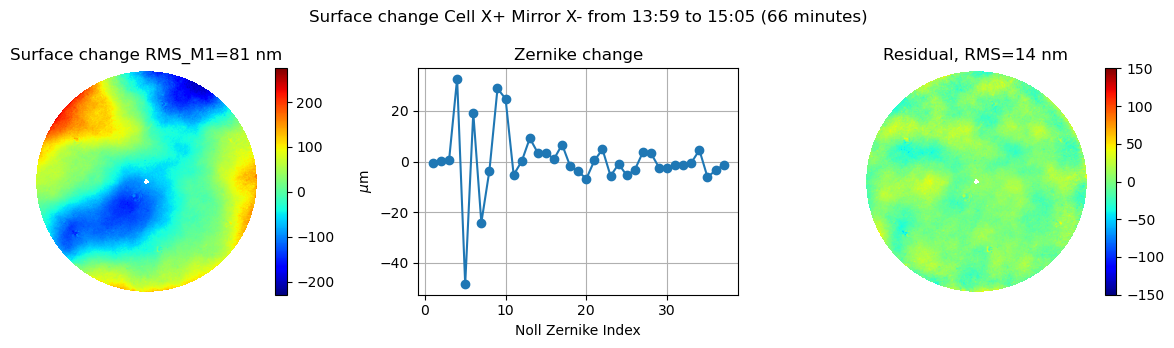

In [4]:
m1s = m1s_cellxp - m1s_init

[x1, y1] = mkXYGrid(m1s, centerRow, centerCol, pixelSize)
r1 = np.sqrt(x1**2 + y1**2)

nnodes = x1.shape[0]*x1.shape[1]
nzer = 37
zerU = np.zeros((nnodes, nzer))
for i in range(nzer):
    zerU[:,i] = zernike_polynomial(i+1, x1/radius_of_CA, y1/radius_of_CA).flatten()

fig, ax = plt.subplots(1,3,figsize=(12,3.5))

maskNew = (~np.isnan(m1s) ) & (r1<radius_of_CA)
nnodesNew = np.sum(maskNew)
mycoeff = zerU[maskNew.flatten(),:].transpose() / nnodesNew @ m1s[maskNew]
recon = np.zeros_like(m1s)
recon[~maskNew] = np.nan
for k in range(nzer):
    recon[maskNew] += mycoeff[k]*zerU[maskNew.flatten(),k]  
residual = m1s - recon

img = ax[0].imshow(m1s*1000, origin='lower') #, vmin=np.nanmin(recon), vmax=np.nanmax(recon))
fig.colorbar(img, ax=ax[0])
fig.suptitle('Surface change Cell X+ Mirror X- from %s to %s (%.0f minutes)'%(ts0[11:16], tscxp[11:16], (unix_ts(tscxp)-unix_ts(ts0))/60. ))

m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
ax[0].set_title('Surface change RMS_M1=%.0f nm'%(m1rms))
ax[0].axis('off')    

i=2
img = ax[i].imshow(residual*1000, origin='lower', vmin=-150, vmax=150)
fig.colorbar(img, ax=ax[i])
m1rms = np.std(residual[~np.isnan(recon)])*1000 #convert into nm
ax[i].set_title('Residual, RMS=%.0f nm'%(m1rms))
ax[i].axis('off')

i=1
ax[i].plot(np.arange(1,nzer+1),1000*mycoeff,'-o')
ax[i].set_title('Zernike change')
ax[i].grid()
ax[i].set_ylabel(r'$\mu$m')
ax[i].set_xlabel('Noll Zernike Index')
plt.tight_layout()

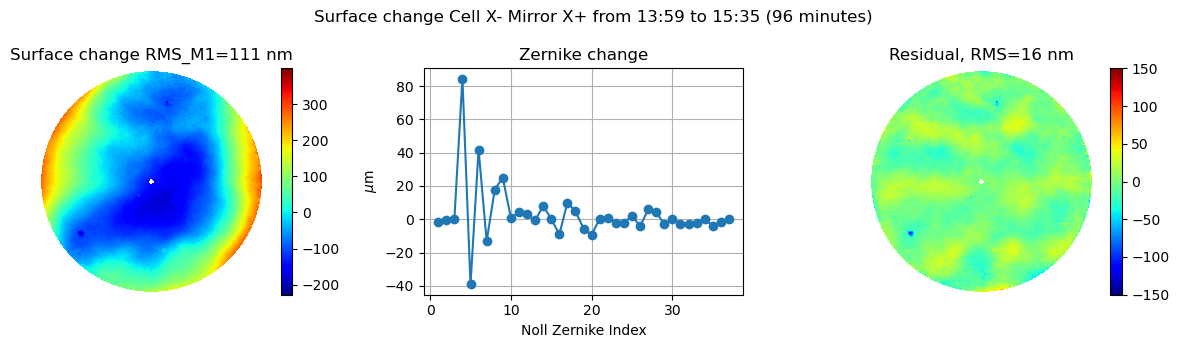

In [5]:
#m1s = m1s_cellxm - m1s_cellxp
m1s = m1s_cellxm - m1s_init

fig, ax = plt.subplots(1,3,figsize=(12,3.5))

maskNew = (~np.isnan(m1s) ) & (r1<radius_of_CA)
nnodesNew = np.sum(maskNew)
mycoeff2 = zerU[maskNew.flatten(),:].transpose() / nnodesNew @ m1s[maskNew]
recon = np.zeros_like(m1s)
recon[~maskNew] = np.nan
for k in range(nzer):
    recon[maskNew] += mycoeff2[k]*zerU[maskNew.flatten(),k]  
residual = m1s - recon

img = ax[0].imshow(m1s*1000, origin='lower') #, vmin=np.nanmin(recon), vmax=np.nanmax(recon))
fig.colorbar(img, ax=ax[0])
#fig.suptitle('Surface change Cell X- Mirror X+ from %s to %s (%.0f minutes)'%(tscxp[11:16], tscxm[11:16], (unix_ts(tscxm)-unix_ts(tscxp))/60. ))
fig.suptitle('Surface change Cell X- Mirror X+ from %s to %s (%.0f minutes)'%(ts0[11:16], tscxm[11:16], (unix_ts(tscxm)-unix_ts(ts0))/60. ))

m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
ax[0].set_title('Surface change RMS_M1=%.0f nm'%(m1rms))
ax[0].axis('off')

i = 2
img = ax[i].imshow(residual*1000, origin='lower', vmin=-150, vmax=150)          
fig.colorbar(img, ax=ax[i])
m1rms = np.std(residual[~np.isnan(recon)])*1000 #convert into nm
ax[i].set_title('Residual, RMS=%.0f nm'%(m1rms))
ax[i].axis('off')

i = 1
ax[1].plot(np.arange(1,nzer+1),1000*mycoeff2,'-o')
ax[1].set_title('Zernike change')
ax[1].grid()
ax[1].set_ylabel(r'$\mu$m')
ax[1].set_xlabel('Noll Zernike Index')
plt.tight_layout()

Text(0.5, 0, 'Noll Zernike Index')

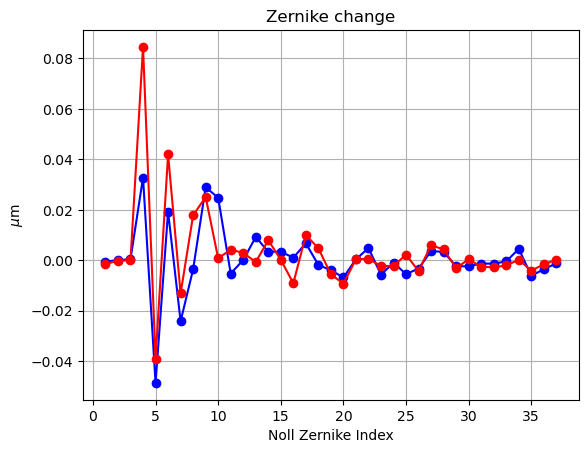

In [6]:
#are these low order terms due to high order thermal drifts? (low order have been compenstated)
# maybe not, z4, z6 went in same direction (what a drift might do), but z5 and z7 pulled back.
plt.plot(np.arange(1,nzer+1),mycoeff,'-bo')
plt.plot(np.arange(1,nzer+1),mycoeff2,'-ro')
plt.title('Zernike change')
plt.grid()
plt.ylabel(r'$\mu$m')
plt.xlabel('Noll Zernike Index')

# Y Decenter

In [7]:
stepN = 18.2
glob_string = '%s/Sec 18/250304/*%.1f*initial*-.h5'%(ml_data_dir, stepN)
fileset = sorted(glob.glob(glob_string))
#print(glob_string, len(fileset))
assert len(fileset)==1
m1s_init,centerRow,centerCol,pixelSize, ts0 = readH5Map(fileset) #, verbose=False)

glob_string = '%s/Sec 18/250304/*%.1f*CellY+*-.h5'%(ml_data_dir, stepN)
fileset = sorted(glob.glob(glob_string))
#print(glob_string, len(fileset))
assert len(fileset)==1
m1s_cellyp,centerRow,centerCol,pixelSize, tscyp = readH5Map(fileset) #, verbose=False)

glob_string = '%s/Sec 18/250304/*%.1f*CellY-*-.h5'%(ml_data_dir, stepN)
fileset = sorted(glob.glob(glob_string))
#print(glob_string, len(fileset))
assert len(fileset)==1
m1s_cellym,centerRow,centerCol,pixelSize, tscym = readH5Map(fileset) #, verbose=False)

/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 18/250304/250304 GMT3 set1 18.2 4 initial gmtMorph170614 comp -.h5: Tue Mar 04 11:44:15 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 18/250304/250304 GMT3 set1 18.2 5-12 CellY+ mir Y- gmtMorph170614 comp -.h5: Tue Mar 04 12:01:29 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 18/250304/250304 GMT3 set1 18.2 5-12 CellY- mir Y+ gmtMorph170614 comp -.h5: Tue Mar 04 12:15:45 2025 


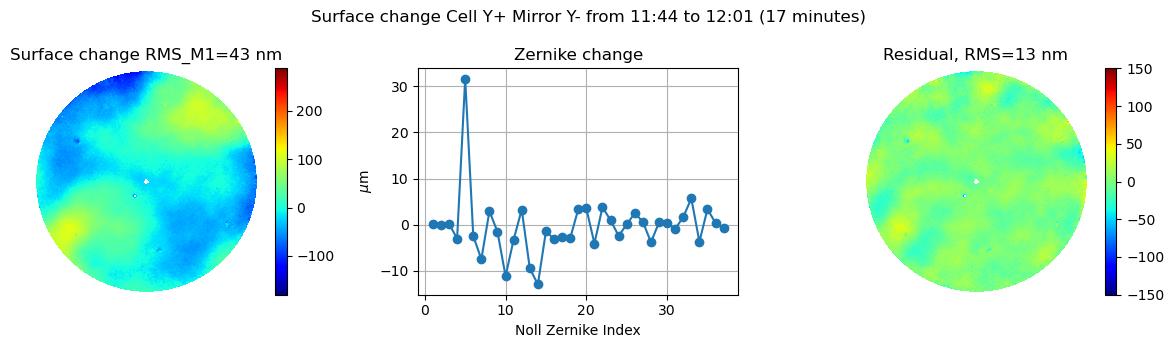

In [8]:
m1s = m1s_cellyp - m1s_init

fig, ax = plt.subplots(1,3,figsize=(12,3.5))

maskNew = (~np.isnan(m1s) ) & (r1<radius_of_CA)
nnodesNew = np.sum(maskNew)
mycoeff = zerU[maskNew.flatten(),:].transpose() / nnodesNew @ m1s[maskNew]
recon = np.zeros_like(m1s)
recon[~maskNew] = np.nan
for k in range(nzer):
    recon[maskNew] += mycoeff[k]*zerU[maskNew.flatten(),k]  
residual = m1s - recon

img = ax[0].imshow(m1s*1000, origin='lower')#, vmin=np.nanmin(recon), vmax=np.nanmax(recon))
fig.colorbar(img, ax=ax[0])
fig.suptitle('Surface change Cell Y+ Mirror Y- from %s to %s (%.0f minutes)'%(ts0[11:16], tscyp[11:16], (unix_ts(tscyp)-unix_ts(ts0))/60. ))

m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
ax[0].set_title('Surface change RMS_M1=%.0f nm'%(m1rms))
ax[0].axis('off')    

i = 2
img = ax[i].imshow(residual*1000, origin='lower', vmin=-150, vmax=150)          
fig.colorbar(img, ax=ax[i])
m1rms = np.std(residual[~np.isnan(recon)])*1000 #convert into nm
ax[i].set_title('Residual, RMS=%.0f nm'%(m1rms))
ax[i].axis('off')

i = 1
ax[i].plot(np.arange(1,nzer+1),1000*mycoeff,'-o')
ax[i].set_title('Zernike change')
ax[i].grid()
ax[i].set_ylabel(r'$\mu$m')
ax[i].set_xlabel('Noll Zernike Index')
plt.tight_layout()

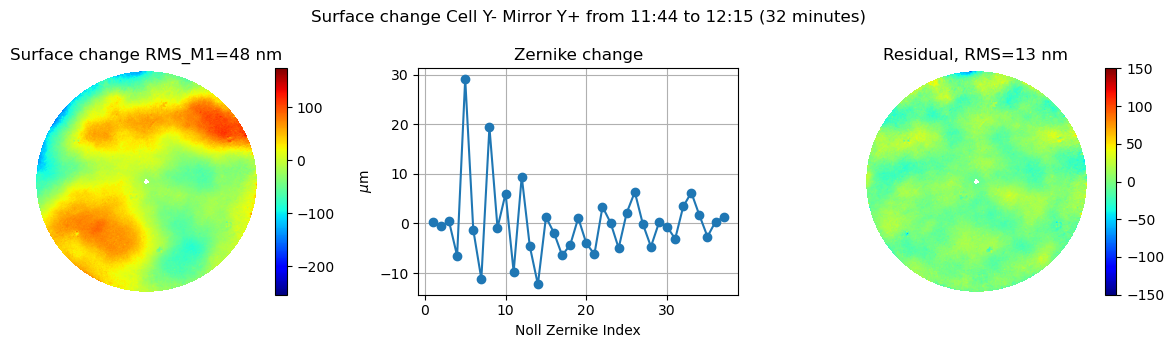

In [9]:
#m1s = m1s_cellxm - m1s_cellxp
m1s = m1s_cellym - m1s_init

fig, ax = plt.subplots(1,3,figsize=(12,3.5))

maskNew = (~np.isnan(m1s) ) & (r1<radius_of_CA)
nnodesNew = np.sum(maskNew)
mycoeff2 = zerU[maskNew.flatten(),:].transpose() / nnodesNew @ m1s[maskNew]
recon = np.zeros_like(m1s)
recon[~maskNew] = np.nan
for k in range(nzer):
    recon[maskNew] += mycoeff2[k]*zerU[maskNew.flatten(),k]  
residual = m1s - recon

img = ax[0].imshow(m1s*1000, origin='lower')#, vmin=np.nanmin(recon), vmax=np.nanmax(recon))
fig.colorbar(img, ax=ax[0])
#fig.suptitle('Surface change Cell X- Mirror X+ from %s to %s (%.0f minutes)'%(tscxp[11:16], tscxm[11:16], (unix_ts(tscxm)-unix_ts(tscxp))/60. ))
fig.suptitle('Surface change Cell Y- Mirror Y+ from %s to %s (%.0f minutes)'%(ts0[11:16], tscym[11:16], (unix_ts(tscym)-unix_ts(ts0))/60. ))

m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
ax[0].set_title('Surface change RMS_M1=%.0f nm'%(m1rms))
ax[0].axis('off')

i = 2
img = ax[i].imshow(residual*1000, origin='lower', vmin=-150, vmax=150)          
fig.colorbar(img, ax=ax[i])
m1rms = np.std(residual[~np.isnan(recon)])*1000 #convert into nm
ax[i].set_title('Residual, RMS=%.0f nm'%(m1rms))
ax[i].axis('off')

i = 1
ax[i].plot(np.arange(1,nzer+1),mycoeff2*1000,'-o')
ax[i].set_title('Zernike change')
ax[i].grid()
ax[i].set_ylabel(r'$\mu$m')
ax[i].set_xlabel('Noll Zernike Index')
plt.tight_layout()

Text(0.5, 0, 'Noll Zernike Index')

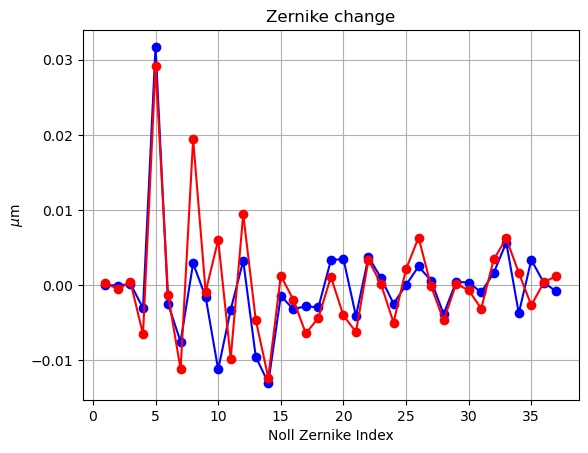

In [10]:
#are these low order terms due to high order thermal drifts? (low order have been compenstated)
# maybe not, z4, z6 went in same direction (what a drift might do), but z5 and z7 pulled back.
plt.plot(np.arange(1,nzer+1),mycoeff,'-bo')
plt.plot(np.arange(1,nzer+1),mycoeff2,'-ro')
plt.title('Zernike change')
plt.grid()
plt.ylabel(r'$\mu$m')
plt.xlabel('Noll Zernike Index')

In [11]:
np.nanmax(m1s)

0.17304657255021993